In [245]:
using ITensors
using Distributions
using HDF5
using Random
using Plots
using Plots.PlotMeasures
using MLDataUtils, StatsBase
using PyCall
using DelimitedFiles
include("../SweepOptRegular.jl");

In [246]:
@pyimport qutip as qt

# Train the MPS

In [247]:
ecg_dat = readdlm("../ECG200_TRAIN.txt")
X_train = ecg_dat[:, 2:end]
y_train = Int.(ecg_dat[:, 1])
remap = Dict(-1 => 0, 1 => 1)
y_train = [remap[label] for label in y_train];
y_train = reshape(y_train, length(y_train), 1);

In [248]:
ecg_dat_test = readdlm("../ECG200_TEST.txt")
X_test = ecg_dat_test[:, 2:end]
y_test = Int.(ecg_dat_test[:, 1])
y_test = [remap[label] for label in y_test]
y_test = reshape(y_test, length(y_test), 1);

In [249]:
struct RobustSigmoidTransform{T<:Real} <: AbstractDataTransform
    median::T
    iqr::T
    k::T
    positive::Bool

    function RobustSigmoidTransform(median::T, iqr::T, k::T, positive=true) where T<:Real
        new{T}(median, iqr, k, positive)
    end
end

function robust_sigmoid(x::Real, median::Real, iqr::Real, k::Real, positive::Bool)
    xhat = 1.0 / (1.0 + exp(-(x - median) / (iqr / k)))
    if !positive
        xhat = 2*xhat - 1
    end
    return xhat
end

function fitScaler(::Type{RobustSigmoidTransform}, X::Matrix; k::Real=1.35, positive::Bool=true)
    medianX = median(X)
    iqrX = iqr(X)
    return RobustSigmoidTransform(medianX, iqrX, k, positive)
end

function transformData(t::RobustSigmoidTransform, X::Matrix)
    return map(x -> robust_sigmoid(x, t.median, t.iqr, t.k, t.positive), X)
end

# New SigmoidTransform
struct SigmoidTransform <: AbstractDataTransform
    positive::Bool
end

function sigmoid(x::Real, positive::Bool)
    xhat = 1.0 / (1.0 + exp(-x))
    if !positive
        xhat = 2*xhat - 1
    end
    return xhat
end

function fitScaler(::Type{SigmoidTransform}, X::Matrix; positive::Bool=true)
    return SigmoidTransform(positive)
end

function transformData(t::SigmoidTransform, X::Matrix)
    return map(x -> sigmoid(x, t.positive), X)
end;

In [250]:
rst = fitScaler(RobustSigmoidTransform, X_train; positive=true)
X_train_normalised = transformData(rst, X_train)
X_test_normalised = transformData(rst, X_test);

In [251]:
W, sites = fitMPS(X_train_normalised, y_train; χ_max=15, nsweep=35, α=0.001, χ_init=2, random_state=42);

Initialising training states.


Parameters: 
Feature map: AngleEncoder
Initial bond dimension χ_init: 2
Step size α: 0.001
Maximum number of sweeps: 35
Maximum bond dimension χ_max: 15
Generating initial weight MPS with bond dimension χ = 2 using random seed 42.


Forward Sweep L -> R (1/35)

Backward Sweep R -> L (1/35)


Training loss after Sweep 1: 0.4984036405236158 | Training Acc: 0.83
ΔC train after sweep 1: 0.0015963594763842015
Forward Sweep L -> R (2/35)


Backward Sweep R -> L (2/35)


Training loss after Sweep 2: 0.3338587577521546 | Training Acc: 0.81
ΔC train after sweep 2: 0.16454488277146118
Forward Sweep L -> R (3/35)


Backward Sweep R -> L (3/35)


Training loss after Sweep 3: 0.2994991859578064 | Training Acc: 0.85
ΔC train after sweep 3: 0.03435957179434823
Forward Sweep L -> R (4/35)


Backward Sweep R -> L (4/35)


Training loss after Sweep 4: 0.28656046707156113 | Training Acc: 0.85
ΔC train after sweep 4: 0.01293871888624526
Forward Sweep L -> R (5/35)


Backward Sweep R -> L (5/35)


Training loss after Sweep 5: 0.27944356240756774 | Training Acc: 0.87
ΔC train after sweep 5: 0.007116904663993395
Forward Sweep L -> R (6/35)


Backward Sweep R -> L (6/35)


Training loss after Sweep 6: 0.2747643157863755 | Training Acc: 0.88
ΔC train after sweep 6: 0.0046792466211922346
Forward Sweep L -> R (7/35)


Backward Sweep R -> L (7/35)


Training loss after Sweep 7: 0.27135076347254544 | Training Acc: 0.89
ΔC train after sweep 7: 0.0034135523138300594
Forward Sweep L -> R (8/35)


Backward Sweep R -> L (8/35)


Training loss after Sweep 8: 0.2686109757210634 | Training Acc: 0.89
ΔC train after sweep 8: 0.002739787751482037
Forward Sweep L -> R (9/35)


Backward Sweep R -> L (9/35)


Training loss after Sweep 9: 0.26638024933380533 | Training Acc: 0.89
ΔC train after sweep 9: 0.002230726387258075
Forward Sweep L -> R (10/35)


Backward Sweep R -> L (10/35)


Training loss after Sweep 10: 0.2647174312187305 | Training Acc: 0.89
ΔC train after sweep 10: 0.0016628181150748489
Forward Sweep L -> R (11/35)


Backward Sweep R -> L (11/35)


Training loss after Sweep 11: 0.2634654166343226 | Training Acc: 0.89
ΔC train after sweep 11: 0.001252014584407879
Forward Sweep L -> R (12/35)


Backward Sweep R -> L (12/35)


Training loss after Sweep 12: 0.26248698828750694 | Training Acc: 0.89
ΔC train after sweep 12: 0.000978428346815663
Forward Sweep L -> R (13/35)


Backward Sweep R -> L (13/35)


Training loss after Sweep 13: 0.2617007850750397 | Training Acc: 0.89
ΔC train after sweep 13: 0.0007862032124672513
Forward Sweep L -> R (14/35)


Backward Sweep R -> L (14/35)


Training loss after Sweep 14: 0.2610452759719822 | Training Acc: 0.9
ΔC train after sweep 14: 0.0006555091030575055
Forward Sweep L -> R (15/35)


Backward Sweep R -> L (15/35)


Training loss after Sweep 15: 0.26047743465980483 | Training Acc: 0.9
ΔC train after sweep 15: 0.0005678413121773529
Forward Sweep L -> R (16/35)


Backward Sweep R -> L (16/35)


Training loss after Sweep 16: 0.2599753710527789 | Training Acc: 0.9
ΔC train after sweep 16: 0.0005020636070259266
Forward Sweep L -> R (17/35)


Backward Sweep R -> L (17/35)


Training loss after Sweep 17: 0.259554950572918 | Training Acc: 0.9
ΔC train after sweep 17: 0.0004204204798609057
Forward Sweep L -> R (18/35)


Backward Sweep R -> L (18/35)


Training loss after Sweep 18: 0.2591871071518902 | Training Acc: 0.9
ΔC train after sweep 18: 0.00036784342102780254
Forward Sweep L -> R (19/35)


Backward Sweep R -> L (19/35)


Training loss after Sweep 19: 0.25886288514951433 | Training Acc: 0.9
ΔC train after sweep 19: 0.0003242220023758624
Forward Sweep L -> R (20/35)


Backward Sweep R -> L (20/35)


Training loss after Sweep 20: 0.25857746726715913 | Training Acc: 0.9
ΔC train after sweep 20: 0.00028541788235519894
Forward Sweep L -> R (21/35)


Backward Sweep R -> L (21/35)


Training loss after Sweep 21: 0.25832668908531675 | Training Acc: 0.9
ΔC train after sweep 21: 0.00025077818184238154
Forward Sweep L -> R (22/35)


Backward Sweep R -> L (22/35)


Training loss after Sweep 22: 0.25810711356469496 | Training Acc: 0.9
ΔC train after sweep 22: 0.0002195755206217953
Forward Sweep L -> R (23/35)


Backward Sweep R -> L (23/35)


Training loss after Sweep 23: 0.25791480331513617 | Training Acc: 0.9
ΔC train after sweep 23: 0.0001923102495587914
Forward Sweep L -> R (24/35)


Backward Sweep R -> L (24/35)


Training loss after Sweep 24: 0.2577486126046631 | Training Acc: 0.9
ΔC train after sweep 24: 0.00016619071047307976
Forward Sweep L -> R (25/35)


Backward Sweep R -> L (25/35)


Training loss after Sweep 25: 0.2576068336338442 | Training Acc: 0.9
ΔC train after sweep 25: 0.00014177897081890656
Forward Sweep L -> R (26/35)


Backward Sweep R -> L (26/35)


Training loss after Sweep 26: 0.2574842287681871 | Training Acc: 0.91
ΔC train after sweep 26: 0.00012260486565707218
Forward Sweep L -> R (27/35)


Backward Sweep R -> L (27/35)


Training loss after Sweep 27: 0.25737871344871555 | Training Acc: 0.91
ΔC train after sweep 27: 0.00010551531947156079
Forward Sweep L -> R (28/35)


Backward Sweep R -> L (28/35)


Training loss after Sweep 28: 0.2572877653352432 | Training Acc: 0.91
ΔC train after sweep 28: 9.094811347232223e-5
Forward Sweep L -> R (29/35)


Backward Sweep R -> L (29/35)


Training loss after Sweep 29: 0.2572113923086087 | Training Acc: 0.91
ΔC train after sweep 29: 7.637302663454637e-5
Forward Sweep L -> R (30/35)


Backward Sweep R -> L (30/35)


Training loss after Sweep 30: 0.2571486803076041 | Training Acc: 0.91
ΔC train after sweep 30: 6.27120010045501e-5
Forward Sweep L -> R (31/35)


Backward Sweep R -> L (31/35)


Training loss after Sweep 31: 0.2570975338706767 | Training Acc: 0.91
ΔC train after sweep 31: 5.1146436927440586e-5
Forward Sweep L -> R (32/35)


Backward Sweep R -> L (32/35)


Training loss after Sweep 32: 0.25705701981306744 | Training Acc: 0.91
ΔC train after sweep 32: 4.0514057609242204e-5
Forward Sweep L -> R (33/35)


Backward Sweep R -> L (33/35)


Training loss after Sweep 33: 0.25702602185950474 | Training Acc: 0.92
ΔC train after sweep 33: 3.099795356270585e-5
Forward Sweep L -> R (34/35)


Backward Sweep R -> L (34/35)


Training loss after Sweep 34: 0.2570034849505818 | Training Acc: 0.92
ΔC train after sweep 34: 2.2536908922954346e-5
Forward Sweep L -> R (35/35)


Backward Sweep R -> L (35/35)


Training loss after Sweep 35: 0.25698907023791756 | Training Acc: 0.92
ΔC train after sweep 35: 1.4414712664223561e-5


In [252]:
ScoreMPS(W, X_test_normalised, y_test)

Initialising testing states.


Test loss: 0.2880074796714118 | Test Accuracy: 0.91


2-element Vector{Float64}:
 0.2880074796714118
 0.91

# Slice the MPS to expose the trained states 

Here, there are two classes and so there are two MPS states - MPS state 0, trained to maximise overlap with class 0 and MPS state 1, trained to maximise overlap with class 1.

In [253]:
function SliceMPS(W::MPS)
    """Gets the label index of the MPS and slices according to the number of classes (dim of the label index)"""
    """Assume one-hot encoding scheme i.e. class 0 = [1, 0], class 1 = [0, 1], etc. """
    dec_index = findindex(W[1], "decision")
    if dec_index == nothing
        error("Label index not found on the first site of the MPS!")
    end

    n_states = ITensors.dim(dec_index)
    states = []
    for i=1:n_states
        state = deepcopy(W)
        if !isapprox(norm(state), 0)
            normalize!(state)
        end
        decision_state = onehot(dec_index => (i))
        println("Class $(i-1) state: $(vector(decision_state))")
        state[1] *= decision_state
        normalize!(state)
        push!(states, state)
    end

    return states
end;

In [254]:
s1, s2 = SliceMPS(W);

Class 0 state: [1.0, 0.0]
Class 1 state: [0.0, 1.0]


Let's check the inner product between the two states. Ideally this should be close to zero, in which case the states are orthogonal. 

In [255]:
inner(s2, s1)

0.11370178587216385

In [256]:
function entropy_von_neumann(ψ::MPS, b::Int)
    psi = deepcopy(ψ)
    s = siteinds(psi)
    orthogonalize!(psi, b) # change orthogonality center to site B
    #print(norm(psi))
    if b == 1
        _, S = svd(psi[b], (siteind(psi, b),))
    else
        _, S = svd(psi[b], (linkind(psi, b-1), s[b]))
    end
    SvN = 0.0
    for n in 1:ITensors.dim(S, 1)
        p = S[n, n]^2
        if p > 1E-12
            SvN -= p * log(p)
        end
    end

    return SvN
end;

In [257]:
entropy_s1 = [entropy_von_neumann(s1, site_idx) for site_idx in 1:length(s1)]
entropy_s2 = [entropy_von_neumann(s2, site_idx) for site_idx in 1:length(s2)]

96-element Vector{Float64}:
  0.06931672617256107
  0.13910698130777352
  0.24341144529019393
  0.3298798900207028
  0.42251883509407095
  0.5310438158171885
  0.6185368771833334
  0.6355934956344337
  0.6793795507159518
  0.6957242159442779
  ⋮
  0.45123133040590363
  0.4218804703754897
  0.3983277689643809
  0.35747121770536117
  0.2745464288099369
  0.1515699962887099
  0.08184899440359583
  0.03449822836478224
 -8.881784197001292e-15

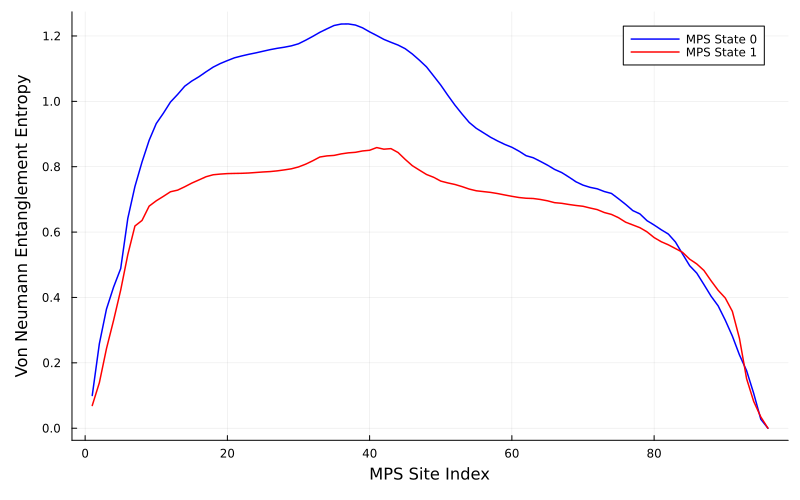

In [258]:
plot(entropy_s1, label="MPS State 0", lw=1.5, color=:blue, size=(800,500), left_margin=5mm, bottom_margin=5mm)
plot!(entropy_s2, label="MPS State 1", lw=1.5, color=:red)
xlabel!("MPS Site Index")
ylabel!("Von Neumann Entanglement Entropy")

Now, obtain the indices for class 0 and class 1 samples:

In [259]:
class_0_indexes = findall(x -> x.== 0, y_train[:, 1])
class_1_indexes = findall(x -> x.== 1, y_train[:, 1])

69-element Vector{Int64}:
   2
   5
   6
   9
  10
  11
  12
  13
  14
  16
   ⋮
  83
  88
  90
  92
  93
  95
  96
  99
 100

# Monte Carlo Approach

## MPS State 0

Let's start by measuring site 1 to be large (maximum value). In other words, let's measure it to be in the $\ket{1}$ state: [0, 1]:
$$\ket{1}_{i=1} \braket{1 | \Psi}_0$$
Where $i$ is the site index, $\ket{\Psi}_0$ is the MPS State corresponding to class 0.
Now, we start by constructing a projector, represented by a single site operator in ITensor, to apply to our site of measurement:
$$ P_{i=1} = \ket{1} \bra{1}$$

In [260]:
s = sites;

In [261]:
zero_state = [1; 0]
one_state = [0; 1];

### Measure Site 1 in MPS State 0

In [262]:
one_state_projector = one_state * one_state'
site_index = 1
one_state_projector_operator = op(one_state_projector, s[site_index])
@show one_state_projector_operator

one_state_projector_operator = ITensor ord=2
Dim 1: (dim=2|id=885|"S=1/2,Site,n=1")'
Dim 2: (dim=2|id=885|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 0.0  0.0
 0.0  1.0


ITensor ord=2 (dim=2|id=885|"S=1/2,Site,n=1")' (dim=2|id=885|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}

In [263]:
site_1_before_measurment = deepcopy(s1[1])
site_1_after_measurement = site_1_before_measurment * one_state_projector_operator
noprime!(site_1_after_measurement)

ITensor ord=2 (dim=4|id=199|"Link,l=1") (dim=2|id=885|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}

Add the measured (updated) site back into the MPS

In [264]:
s1[1] = site_1_after_measurement

ITensor ord=2 (dim=4|id=199|"Link,l=1") (dim=2|id=885|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}

Normalise the updated MPS

In [265]:
normalize!(s1)

MPS
[1] ((dim=4|id=199|"Link,l=1"), (dim=2|id=885|"S=1/2,Site,n=1"))
[2] ((dim=2|id=659|"S=1/2,Site,n=2"), (dim=8|id=148|"Link,l=2"), (dim=4|id=199|"Link,l=1"))
[3] ((dim=2|id=236|"S=1/2,Site,n=3"), (dim=15|id=793|"Link,l=3"), (dim=8|id=148|"Link,l=2"))
[4] ((dim=2|id=298|"S=1/2,Site,n=4"), (dim=15|id=998|"Link,l=4"), (dim=15|id=793|"Link,l=3"))
[5] ((dim=2|id=949|"S=1/2,Site,n=5"), (dim=15|id=311|"Link,l=5"), (dim=15|id=998|"Link,l=4"))
[6] ((dim=2|id=283|"S=1/2,Site,n=6"), (dim=15|id=364|"Link,l=6"), (dim=15|id=311|"Link,l=5"))
[7] ((dim=2|id=372|"S=1/2,Site,n=7"), (dim=15|id=861|"Link,l=7"), (dim=15|id=364|"Link,l=6"))
[8] ((dim=2|id=796|"S=1/2,Site,n=8"), (dim=15|id=646|"Link,l=8"), (dim=15|id=861|"Link,l=7"))
[9] ((dim=2|id=303|"S=1/2,Site,n=9"), (dim=15|id=877|"Link,l=9"), (dim=15|id=646|"Link,l=8"))
[10] ((dim=2|id=292|"S=1/2,Site,n=10"), (dim=15|id=565|"Link,l=10"), (dim=15|id=877|"Link,l=9"))
[11] ((dim=2|id=886|"S=1/2,Site,n=11"), (dim=15|id=189|"Link,l=11"), (dim=15|id=565|"

Get the EE after making the measurement at site 1

In [266]:
entropy_s1_after_measure_site_1 = [entropy_von_neumann(s1, site_idx) for site_idx in 1:length(s1)]

96-element Vector{Float64}:
 -6.217248937900896e-15
  0.16854300446301046
  0.2635335165748251
  0.3210264620447179
  0.37504365340503515
  0.5457360068363821
  0.654382031022607
  0.7340183949353389
  0.8056259584578652
  0.8608665913739666
  ⋮
  0.41072477930054835
  0.37928615147794065
  0.3336766655534662
  0.2826536702237406
  0.22448789889675683
  0.1753857833761581
  0.10549594520323717
  0.02666359068149311
 -6.661338147750961e-15

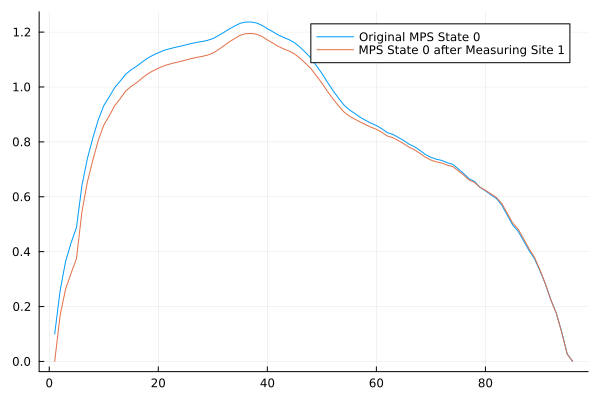

In [267]:
plot(entropy_s1, label="Original MPS State 0")
plot!(entropy_s1_after_measure_site_1, label="MPS State 0 after Measuring Site 1")

### Obtain the density matrix for site 2

Now that we have measured site 1 and altered the MPS, lets get $\rho$ for site 2. We start by shifting the orthogonality center to site 2, allowing us to greatly simplify subsequent calculations (since sites to left of the orthogonality center reduce to identity and sites to the right of the orthogonality center contract to identity).

In [268]:
orthogonalize!(s1, 2)

MPS
[1] ((dim=2|id=885|"S=1/2,Site,n=1"), (dim=2|id=880|"Link,l=1"))
[2] ((dim=2|id=659|"S=1/2,Site,n=2"), (dim=2|id=880|"Link,l=1"), (dim=8|id=803|"Link,l=2"))
[3] ((dim=2|id=236|"S=1/2,Site,n=3"), (dim=15|id=634|"Link,l=3"), (dim=8|id=803|"Link,l=2"))
[4] ((dim=2|id=298|"S=1/2,Site,n=4"), (dim=15|id=375|"Link,l=4"), (dim=15|id=634|"Link,l=3"))
[5] ((dim=2|id=949|"S=1/2,Site,n=5"), (dim=15|id=154|"Link,l=5"), (dim=15|id=375|"Link,l=4"))
[6] ((dim=2|id=283|"S=1/2,Site,n=6"), (dim=15|id=283|"Link,l=6"), (dim=15|id=154|"Link,l=5"))
[7] ((dim=2|id=372|"S=1/2,Site,n=7"), (dim=15|id=967|"Link,l=7"), (dim=15|id=283|"Link,l=6"))
[8] ((dim=2|id=796|"S=1/2,Site,n=8"), (dim=15|id=352|"Link,l=8"), (dim=15|id=967|"Link,l=7"))
[9] ((dim=2|id=303|"S=1/2,Site,n=9"), (dim=15|id=450|"Link,l=9"), (dim=15|id=352|"Link,l=8"))
[10] ((dim=2|id=292|"S=1/2,Site,n=10"), (dim=15|id=638|"Link,l=10"), (dim=15|id=450|"Link,l=9"))
[11] ((dim=2|id=886|"S=1/2,Site,n=11"), (dim=15|id=800|"Link,l=11"), (dim=15|id=638|"

In [269]:
ρ2 = prime(s1[2], s[2]) * dag(s1[2]);
ρ2 = matrix(ρ2)

2×2 Matrix{Float64}:
 0.15277   0.301427
 0.301427  0.84723

Get the trace and check if Hermitian.

In [270]:
tr(ρ2), isequal(ρ2, adjoint(ρ2))

(1.0000000000000064, true)

#### Diagonalise the density matrix $\rho$ to get the eigenvalues (probabilities) and eigenstates (basis vectors).

In [271]:
eig_vals, eig_vecs = eigen(ρ2);
println(eig_vals)
println(eig_vecs)

[0.04018858053388191, 0.9598114194661246]
[-0.9367914637324803 0.3498882013986141; 0.3498882013986141 0.9367914637324803]


Assign the first eigenvalue to p1 and the second to p2 (probabilities of their resepctive eigenstates):

In [272]:
p1 = eig_vals[1]
p2 = eig_vals[2]

v1 = eig_vecs[:, 1]
v2 = eig_vecs[:, 2];
println("Probability of state $v1: $p1")
println("Probability of state $v2: $p2")

Probability of state [-0.9367914637324803, 0.3498882013986141]: 0.04018858053388191
Probability of state [0.3498882013986141, 0.9367914637324803]: 0.9598114194661246


In [273]:
v2

2-element Vector{Float64}:
 0.3498882013986141
 0.9367914637324803

In [274]:
v1

2-element Vector{Float64}:
 -0.9367914637324803
  0.3498882013986141

Plot $\ket{v_1}$ and $\ket{v_2}$ (imported from python's qutip library)

In [275]:
function TransformEigenstates(v1, v2)
    # check the eigenstates to see if they lie in the domain
    if v1[1] < 0
        # flip
        v1[1] = -v1[1]
    end

    if v2[1] < 0
        # flip
        v2[1] = -v2[1]
    end

    return v1, v2
end


TransformEigenstates (generic function with 1 method)

In [276]:
v1_new, v2_new = TransformEigenstates(v1, v2)

([0.9367914637324803, 0.3498882013986141], [0.3498882013986141, 0.9367914637324803])

#### Generate random number between 0 and 1 and choose an outcome

In [277]:
r = rand()
if r <= p1
    println("Chosen eigenstate 1")
    v_chosen = v1
else
    println("Chosen eigenstate 2")
    v_chosen = v2
end
    

Chosen eigenstate 2


2-element Vector{Float64}:
 0.3498882013986141
 0.9367914637324803

#### Apply the inverse of the feature map to recover the time-series value

In [278]:
function InverseFeatureMap(encoding::Vector)
    θ = atan(encoding[2], encoding[1])
    x = (2 * θ) / π
    return x
end;

In [279]:
InverseFeatureMap(v_chosen)

0.7724391425858189

This is our time-series value at site 2, given having measured site 1 to be large (1.0).

#### Update the MPS using the outcome for site 2

Now that we have used our monte-carlo simulation to get an outcome from the density matrix at site 2, we need to update the MPS state by making this measurement at site 2. This will then give us the MPS state, conditonal upon having `measured` site 1 to be 1.0 and site 2 to be 0.77. 

Once again, we start by constructing the projector and then applying the operator to site 2.

In [280]:
projector_site_2 = v_chosen * v_chosen'
projector_site_2_operator = op(projector_site_2, s[2])
@show projector_site_2_operator

projector_site_2_operator = ITensor ord=2
Dim 1: (dim=2|id=659|"S=1/2,Site,n=2")'
Dim 2: (dim=2|id=659|"S=1/2,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 0.12242175347795714  0.3277722803309326
 0.3277722803309326   0.8775782465220431


ITensor ord=2 (dim=2|id=659|"S=1/2,Site,n=2")' (dim=2|id=659|"S=1/2,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}

In [281]:
site_2_before_measure = deepcopy(s1[2])
site_2_after_measure = site_2_before_measure * projector_site_2_operator
noprime!(site_2_after_measure)

ITensor ord=3 (dim=2|id=880|"Link,l=1") (dim=8|id=803|"Link,l=2") (dim=2|id=659|"S=1/2,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}

Add updated site 2 back into the MPS

In [282]:
s1[2] = site_2_after_measure;

And normalise the updated MPS

In [283]:
normalize!(s1);

### Obtain the density matrix for site 3

In [284]:
orthogonalize!(s1, 3)

MPS
[1] ((dim=2|id=885|"S=1/2,Site,n=1"), (dim=2|id=880|"Link,l=1"))
[2] ((dim=2|id=880|"Link,l=1"), (dim=2|id=659|"S=1/2,Site,n=2"), (dim=4|id=314|"Link,l=2"))
[3] ((dim=2|id=236|"S=1/2,Site,n=3"), (dim=15|id=634|"Link,l=3"), (dim=4|id=314|"Link,l=2"))
[4] ((dim=2|id=298|"S=1/2,Site,n=4"), (dim=15|id=375|"Link,l=4"), (dim=15|id=634|"Link,l=3"))
[5] ((dim=2|id=949|"S=1/2,Site,n=5"), (dim=15|id=154|"Link,l=5"), (dim=15|id=375|"Link,l=4"))
[6] ((dim=2|id=283|"S=1/2,Site,n=6"), (dim=15|id=283|"Link,l=6"), (dim=15|id=154|"Link,l=5"))
[7] ((dim=2|id=372|"S=1/2,Site,n=7"), (dim=15|id=967|"Link,l=7"), (dim=15|id=283|"Link,l=6"))
[8] ((dim=2|id=796|"S=1/2,Site,n=8"), (dim=15|id=352|"Link,l=8"), (dim=15|id=967|"Link,l=7"))
[9] ((dim=2|id=303|"S=1/2,Site,n=9"), (dim=15|id=450|"Link,l=9"), (dim=15|id=352|"Link,l=8"))
[10] ((dim=2|id=292|"S=1/2,Site,n=10"), (dim=15|id=638|"Link,l=10"), (dim=15|id=450|"Link,l=9"))
[11] ((dim=2|id=886|"S=1/2,Site,n=11"), (dim=15|id=800|"Link,l=11"), (dim=15|id=638|"

In [285]:
ρ3 = prime(s1[3], s[3]) * dag(s1[3])
ρ3 = matrix(ρ3)

2×2 Matrix{Float64}:
 0.121771  0.275304
 0.275304  0.878229

In [286]:
tr(ρ3), isequal(ρ3, adjoint(ρ3))

(1.0000000000000004, true)

Diagonalise $\rho$

In [287]:
eig_vals, eig_vecs = eigen(ρ3)

LinearAlgebra.Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 0.03218595963829836
 0.9678140403617022
vectors:
2×2 Matrix{Float64}:
 -0.950922  0.309432
  0.309432  0.950922

In [288]:
p1 = eig_vals[1]
p2 = eig_vals[2]
print(p1 + p2)

v1 = eig_vecs[:, 1]
v2 = eig_vecs[:, 2];
print(v1, v2)

1.0000000000000004[-0.9509215626885478, 0.3094320306852057][0.3094320306852057, 0.9509215626885478]

In [289]:
v1, v2 = TransformEigenstates(v1, v2)

([0.9509215626885478, 0.3094320306852057], [0.3094320306852057, 0.9509215626885478])

#### Generate random number and select outcome

In [290]:
r = rand()
if r <= p1
    println("Chosen eigenstate 1")
    v_chosen = v1
else
    println("Chosen eigenstate 2")
    v_chosen = v2
end

Chosen eigenstate 2


2-element Vector{Float64}:
 0.3094320306852057
 0.9509215626885478

#### Convert to time-series value

In [291]:
InverseFeatureMap(v_chosen)

0.7997221626052511

#### Make measurement on the MPS

In [292]:
site_3_projector = v_chosen * v_chosen'
site_3_projector_operator = op(site_3_projector, s[3])

ITensor ord=2 (dim=2|id=236|"S=1/2,Site,n=3")' (dim=2|id=236|"S=1/2,Site,n=3")
NDTensors.Dense{Float64, Vector{Float64}}

In [293]:
site_3_before_measure = s1[3]
site_3_after_measure = site_3_before_measure * site_3_projector_operator

ITensor ord=3 (dim=15|id=634|"Link,l=3") (dim=4|id=314|"Link,l=2") (dim=2|id=236|"S=1/2,Site,n=3")'
NDTensors.Dense{Float64, Vector{Float64}}

In [294]:
noprime!(site_3_after_measure)

ITensor ord=3 (dim=15|id=634|"Link,l=3") (dim=4|id=314|"Link,l=2") (dim=2|id=236|"S=1/2,Site,n=3")
NDTensors.Dense{Float64, Vector{Float64}}

In [295]:
s1[3] = site_3_after_measure

ITensor ord=3 (dim=15|id=634|"Link,l=3") (dim=4|id=314|"Link,l=2") (dim=2|id=236|"S=1/2,Site,n=3")
NDTensors.Dense{Float64, Vector{Float64}}

In [296]:
normalize!(s1);

# Obtain density Matrix for Site 4

In [297]:
orthogonalize!(s1, 4);

In [298]:
ρ4 = prime(s1[4], s[4]) * dag(s1[4])

ITensor ord=2 (dim=2|id=298|"S=1/2,Site,n=4")' (dim=2|id=298|"S=1/2,Site,n=4")
NDTensors.Dense{Float64, Vector{Float64}}

In [299]:
ρ4 = matrix(ρ4)

2×2 Matrix{Float64}:
 0.0819669  0.242622
 0.242622   0.918033

In [300]:
tr(ρ4), isequal(ρ4, adjoint(ρ4))

(1.0, true)

In [301]:
eig_vals, eig_vecs = eigen(ρ4)

LinearAlgebra.Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 0.016660602065091942
 0.9833393979349081
vectors:
2×2 Matrix{Float64}:
 -0.965631  0.259918
  0.259918  0.965631

In [302]:
p1 = eig_vals[1]
p2 = eig_vals[2]

v1 = eig_vecs[:, 1]
v2 = eig_vecs[:, 2]

2-element Vector{Float64}:
 0.25991812146116616
 0.9656306592771889

In [303]:
v1, v2 = TransformEigenstates(v1, v2)

([0.9656306592771889, 0.25991812146116616], [0.25991812146116616, 0.9656306592771889])

In [304]:
r = rand()
if r <= p1
    println("Chosen eigenstate 1")
    v_chosen = v1
else
    println("Chosen eigenstate 2")
    v_chosen = v2
end

Chosen eigenstate 2


2-element Vector{Float64}:
 0.25991812146116616
 0.9656306592771889

In [305]:
InverseFeatureMap(v_chosen)

0.832608846453483

#### Make measurement on the MPS (@ site 4)

In [306]:
site_4_projector = v_chosen * v_chosen'
site_4_projector_operator = op(site_4_projector, s[4])
@show site_4_projector_operator

site_4_projector_operator = ITensor ord=2
Dim 1: (dim=2|id=298|"S=1/2,Site,n=4")'
Dim 2: (dim=2|id=298|"S=1/2,Site,n=4")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 0.06755742986390152  0.2509849069846343
 0.2509849069846343   0.9324425701360985


ITensor ord=2 (dim=2|id=298|"S=1/2,Site,n=4")' (dim=2|id=298|"S=1/2,Site,n=4")
NDTensors.Dense{Float64, Vector{Float64}}

In [307]:
site_4_before_measure = s1[4]
site_4_after_measure = site_4_before_measure * site_4_projector_operator
noprime!(site_4_after_measure);

In [308]:
s1[4] = site_4_after_measure

ITensor ord=3 (dim=15|id=375|"Link,l=4") (dim=8|id=244|"Link,l=3") (dim=2|id=298|"S=1/2,Site,n=4")
NDTensors.Dense{Float64, Vector{Float64}}

In [309]:
normalize!(s1)

MPS
[1] ((dim=2|id=885|"S=1/2,Site,n=1"), (dim=2|id=880|"Link,l=1"))
[2] ((dim=2|id=880|"Link,l=1"), (dim=2|id=659|"S=1/2,Site,n=2"), (dim=4|id=314|"Link,l=2"))
[3] ((dim=4|id=314|"Link,l=2"), (dim=2|id=236|"S=1/2,Site,n=3"), (dim=8|id=244|"Link,l=3"))
[4] ((dim=15|id=375|"Link,l=4"), (dim=8|id=244|"Link,l=3"), (dim=2|id=298|"S=1/2,Site,n=4"))
[5] ((dim=2|id=949|"S=1/2,Site,n=5"), (dim=15|id=154|"Link,l=5"), (dim=15|id=375|"Link,l=4"))
[6] ((dim=2|id=283|"S=1/2,Site,n=6"), (dim=15|id=283|"Link,l=6"), (dim=15|id=154|"Link,l=5"))
[7] ((dim=2|id=372|"S=1/2,Site,n=7"), (dim=15|id=967|"Link,l=7"), (dim=15|id=283|"Link,l=6"))
[8] ((dim=2|id=796|"S=1/2,Site,n=8"), (dim=15|id=352|"Link,l=8"), (dim=15|id=967|"Link,l=7"))
[9] ((dim=2|id=303|"S=1/2,Site,n=9"), (dim=15|id=450|"Link,l=9"), (dim=15|id=352|"Link,l=8"))
[10] ((dim=2|id=292|"S=1/2,Site,n=10"), (dim=15|id=638|"Link,l=10"), (dim=15|id=450|"Link,l=9"))
[11] ((dim=2|id=886|"S=1/2,Site,n=11"), (dim=15|id=800|"Link,l=11"), (dim=15|id=638|"Li

In [310]:
norm(s1)

0.9999999999999999

# Obtain density matrix $\rho$ for site 5

In [311]:
orthogonalize!(s1, 5)

MPS
[1] ((dim=2|id=885|"S=1/2,Site,n=1"), (dim=2|id=880|"Link,l=1"))
[2] ((dim=2|id=880|"Link,l=1"), (dim=2|id=659|"S=1/2,Site,n=2"), (dim=4|id=314|"Link,l=2"))
[3] ((dim=4|id=314|"Link,l=2"), (dim=2|id=236|"S=1/2,Site,n=3"), (dim=8|id=244|"Link,l=3"))
[4] ((dim=8|id=244|"Link,l=3"), (dim=2|id=298|"S=1/2,Site,n=4"), (dim=15|id=895|"Link,l=4"))
[5] ((dim=2|id=949|"S=1/2,Site,n=5"), (dim=15|id=154|"Link,l=5"), (dim=15|id=895|"Link,l=4"))
[6] ((dim=2|id=283|"S=1/2,Site,n=6"), (dim=15|id=283|"Link,l=6"), (dim=15|id=154|"Link,l=5"))
[7] ((dim=2|id=372|"S=1/2,Site,n=7"), (dim=15|id=967|"Link,l=7"), (dim=15|id=283|"Link,l=6"))
[8] ((dim=2|id=796|"S=1/2,Site,n=8"), (dim=15|id=352|"Link,l=8"), (dim=15|id=967|"Link,l=7"))
[9] ((dim=2|id=303|"S=1/2,Site,n=9"), (dim=15|id=450|"Link,l=9"), (dim=15|id=352|"Link,l=8"))
[10] ((dim=2|id=292|"S=1/2,Site,n=10"), (dim=15|id=638|"Link,l=10"), (dim=15|id=450|"Link,l=9"))
[11] ((dim=2|id=886|"S=1/2,Site,n=11"), (dim=15|id=800|"Link,l=11"), (dim=15|id=638|"Li

In [312]:
ρ5 = prime(s1[5], s[5]) * dag(s1[5])
ρ5 = matrix(ρ5) 

2×2 Matrix{Float64}:
 0.100799  0.282924
 0.282924  0.899201

In [313]:
tr(ρ5), isequal(ρ5, adjoint(ρ5))

(0.9999999999999999, true)

In [314]:
eig_vals, eig_vecs = eigen(ρ5)

LinearAlgebra.Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 0.010707001140518077
 0.9892929988594819
vectors:
2×2 Matrix{Float64}:
 -0.952857  0.303419
  0.303419  0.952857

In [315]:
p1 = eig_vals[1]
p2 = eig_vals[2]

v1 = eig_vecs[:, 1]
v2 = eig_vecs[:, 2]
print(v1)
print(v2)

[-0.9528571091299792, 0.3034193955245099][0.3034193955245099, 0.9528571091299792]

In [316]:
v1, v2 = TransformEigenstates(v1, v2)

([0.9528571091299792, 0.3034193955245099], [0.3034193955245099, 0.9528571091299792])

In [317]:
r = rand()
if r <= p1
    println("Chosen eigenstate 1")
    v_chosen = v1
else
    println("Chosen eigenstate 2")
    v_chosen = v2
end

Chosen eigenstate 2


2-element Vector{Float64}:
 0.3034193955245099
 0.9528571091299792

In [318]:
InverseFeatureMap(v_chosen)

0.803743375530085

#### Make Measurement on the MPS @ site 5

In [319]:
site_5_projector = v_chosen * v_chosen'
site_5_projector_operator = op(site_5_projector, s[5])

ITensor ord=2 (dim=2|id=949|"S=1/2,Site,n=5")' (dim=2|id=949|"S=1/2,Site,n=5")
NDTensors.Dense{Float64, Vector{Float64}}

In [320]:
site_5_before_measure = s1[5]
site_5_after_measure = site_5_before_measure * site_5_projector_operator

ITensor ord=3 (dim=15|id=154|"Link,l=5") (dim=15|id=895|"Link,l=4") (dim=2|id=949|"S=1/2,Site,n=5")'
NDTensors.Dense{Float64, Vector{Float64}}

In [321]:
noprime!(site_5_after_measure)

ITensor ord=3 (dim=15|id=154|"Link,l=5") (dim=15|id=895|"Link,l=4") (dim=2|id=949|"S=1/2,Site,n=5")
NDTensors.Dense{Float64, Vector{Float64}}

In [322]:
s1[5] = site_5_after_measure

ITensor ord=3 (dim=15|id=154|"Link,l=5") (dim=15|id=895|"Link,l=4") (dim=2|id=949|"S=1/2,Site,n=5")
NDTensors.Dense{Float64, Vector{Float64}}

In [323]:
normalize!(s1)

MPS
[1] ((dim=2|id=885|"S=1/2,Site,n=1"), (dim=2|id=880|"Link,l=1"))
[2] ((dim=2|id=880|"Link,l=1"), (dim=2|id=659|"S=1/2,Site,n=2"), (dim=4|id=314|"Link,l=2"))
[3] ((dim=4|id=314|"Link,l=2"), (dim=2|id=236|"S=1/2,Site,n=3"), (dim=8|id=244|"Link,l=3"))
[4] ((dim=8|id=244|"Link,l=3"), (dim=2|id=298|"S=1/2,Site,n=4"), (dim=15|id=895|"Link,l=4"))
[5] ((dim=15|id=154|"Link,l=5"), (dim=15|id=895|"Link,l=4"), (dim=2|id=949|"S=1/2,Site,n=5"))
[6] ((dim=2|id=283|"S=1/2,Site,n=6"), (dim=15|id=283|"Link,l=6"), (dim=15|id=154|"Link,l=5"))
[7] ((dim=2|id=372|"S=1/2,Site,n=7"), (dim=15|id=967|"Link,l=7"), (dim=15|id=283|"Link,l=6"))
[8] ((dim=2|id=796|"S=1/2,Site,n=8"), (dim=15|id=352|"Link,l=8"), (dim=15|id=967|"Link,l=7"))
[9] ((dim=2|id=303|"S=1/2,Site,n=9"), (dim=15|id=450|"Link,l=9"), (dim=15|id=352|"Link,l=8"))
[10] ((dim=2|id=292|"S=1/2,Site,n=10"), (dim=15|id=638|"Link,l=10"), (dim=15|id=450|"Link,l=9"))
[11] ((dim=2|id=886|"S=1/2,Site,n=11"), (dim=15|id=800|"Link,l=11"), (dim=15|id=638|"Li

## Summary from small-scale test

Given we measure site 1 to be 1.0 ($\ket{1}$ state), the outcome from a single run of the 'monte-carlo' simulation for sites 2, 3, 4, and 5 were:
$$[1.0, 0.7724391425858189, 0.7997221626052511, 0.832608846453483, 0.803743375530085]$$

This was a small scale test - we only measured the first five sites, did a single run and chose to start with the first site. Next, we will need to scale this up to measure all sites (doesn't necessarily have to start at site 1) and then repeat for N simulations in order to get a distribution of values for each site. From this distribution, we can then get a mean and std dev.

---------

As an intermediate step, we will generate a function which starts by measuring the first site to be x.

In [324]:
function ChooseOutcome(p1, p2, v1, v2; verbose=false)
    if p1 > p2
        error("p1 must be smaller than p2")
    end
    r = rand()
    if r <= p1
        if verbose==true
            println("Chose eigenstate 1")
        end
        return v1
    else
        if verbose == true
            println("Chose eigenstate 2")
        end
        return v2
    end
end; 

In [325]:
function MonteCarlo(ψ::MPS, site_1_measurement::Vector)
    """Pass in encoded (feature mapped) value for the time-series measurement"""
    psi = deepcopy(ψ)
    s = siteinds(ψ)

    measurements = [] # store the site-wise measurements
    push!(measurements, InverseFeatureMap(site_1_measurement))

    # construct projector for the first site
    projector_site_1 = site_1_measurement * site_1_measurement'
    projector_site_1_operator = op(projector_site_1, s[1])

    site_1_before_measurement = deepcopy(psi[1])
    site_1_after_measurement = site_1_before_measurement * projector_site_1_operator
    noprime!(site_1_after_measurement)

    # add into the MPS
    psi[1] = site_1_after_measurement
    # normalise the MPS after updating
    normalize!(psi)
    outcome_eigenstates = []
    all_eigenstates = []

    # start loop
    for i=2:length(psi)
        orthogonalize!(psi, i)
        ρ = prime(psi[i], s[i]) * dag(psi[i])
        ρ = matrix(ρ)
        eig_vals, eig_vecs = eigen(ρ)

        p1 = eig_vals[1]
        p2 = eig_vals[2]

        v1 = eig_vecs[:, 1]
        v2 = eig_vecs[:, 2]

        # Experimental -> reflect eigenstates outside of the domain back into the domain
        v1 = abs.(v1)
        v2 = abs.(v2)
        #v1, v2 = TransformEigenstates(v1, v2)
        

        outcome = ChooseOutcome(p1, p2, v1, v2)
        push!(outcome_eigenstates, outcome)
        push!(all_eigenstates, [v1, v2])
        
        # convert outcome (as encoded vector) back into normalised time-series value
        x = InverseFeatureMap(outcome)
        push!(measurements, x)

        # make projector
        projector = outcome * outcome'
        projector_op = op(projector, s[i])

        # apply projector at site i in MPS
        site_before_measurement = deepcopy(psi[i])
        site_after_measurement = site_before_measurement * projector_op
        noprime!(site_after_measurement)

        # add into the MPS
        psi[i] = site_after_measurement
        normalize!(psi)

    end

    return measurements

end;


In [326]:
s1, s2 = SliceMPS(W);

Class 0 state: [1.0, 0.0]
Class 1 state: [0.0, 1.0]


In [327]:
one_state = [0.0; 1.0]
zero_state = [1.0; 0.0]
ms = MonteCarlo(s1, zero_state);

In [334]:
sims = []
for i=1:10000
    if i % 1000 == 0
        println(i)
    end
    #println("Sim $i")
    ms = MonteCarlo(s1, [0.45399049973954686, 0.8910065241883678]);
    push!(sims, ms)
end

1000


2000


3000


4000


5000


6000


7000


8000


9000


10000


In [335]:
mean(sims)

96-element Vector{Float64}:
 0.6999999999999925
 0.7236620281544998
 0.7518140047150852
 0.7997082048289136
 0.7930387225681371
 0.6916064885251115
 0.6492971136109903
 0.6035331134300376
 0.535549777356841
 0.48105386878330175
 ⋮
 0.5932420658856297
 0.6040934145207105
 0.6408487192617957
 0.661103660256614
 0.6708665728997439
 0.6356824106821607
 0.6471149796366717
 0.6607112999593243
 0.5844869909127473

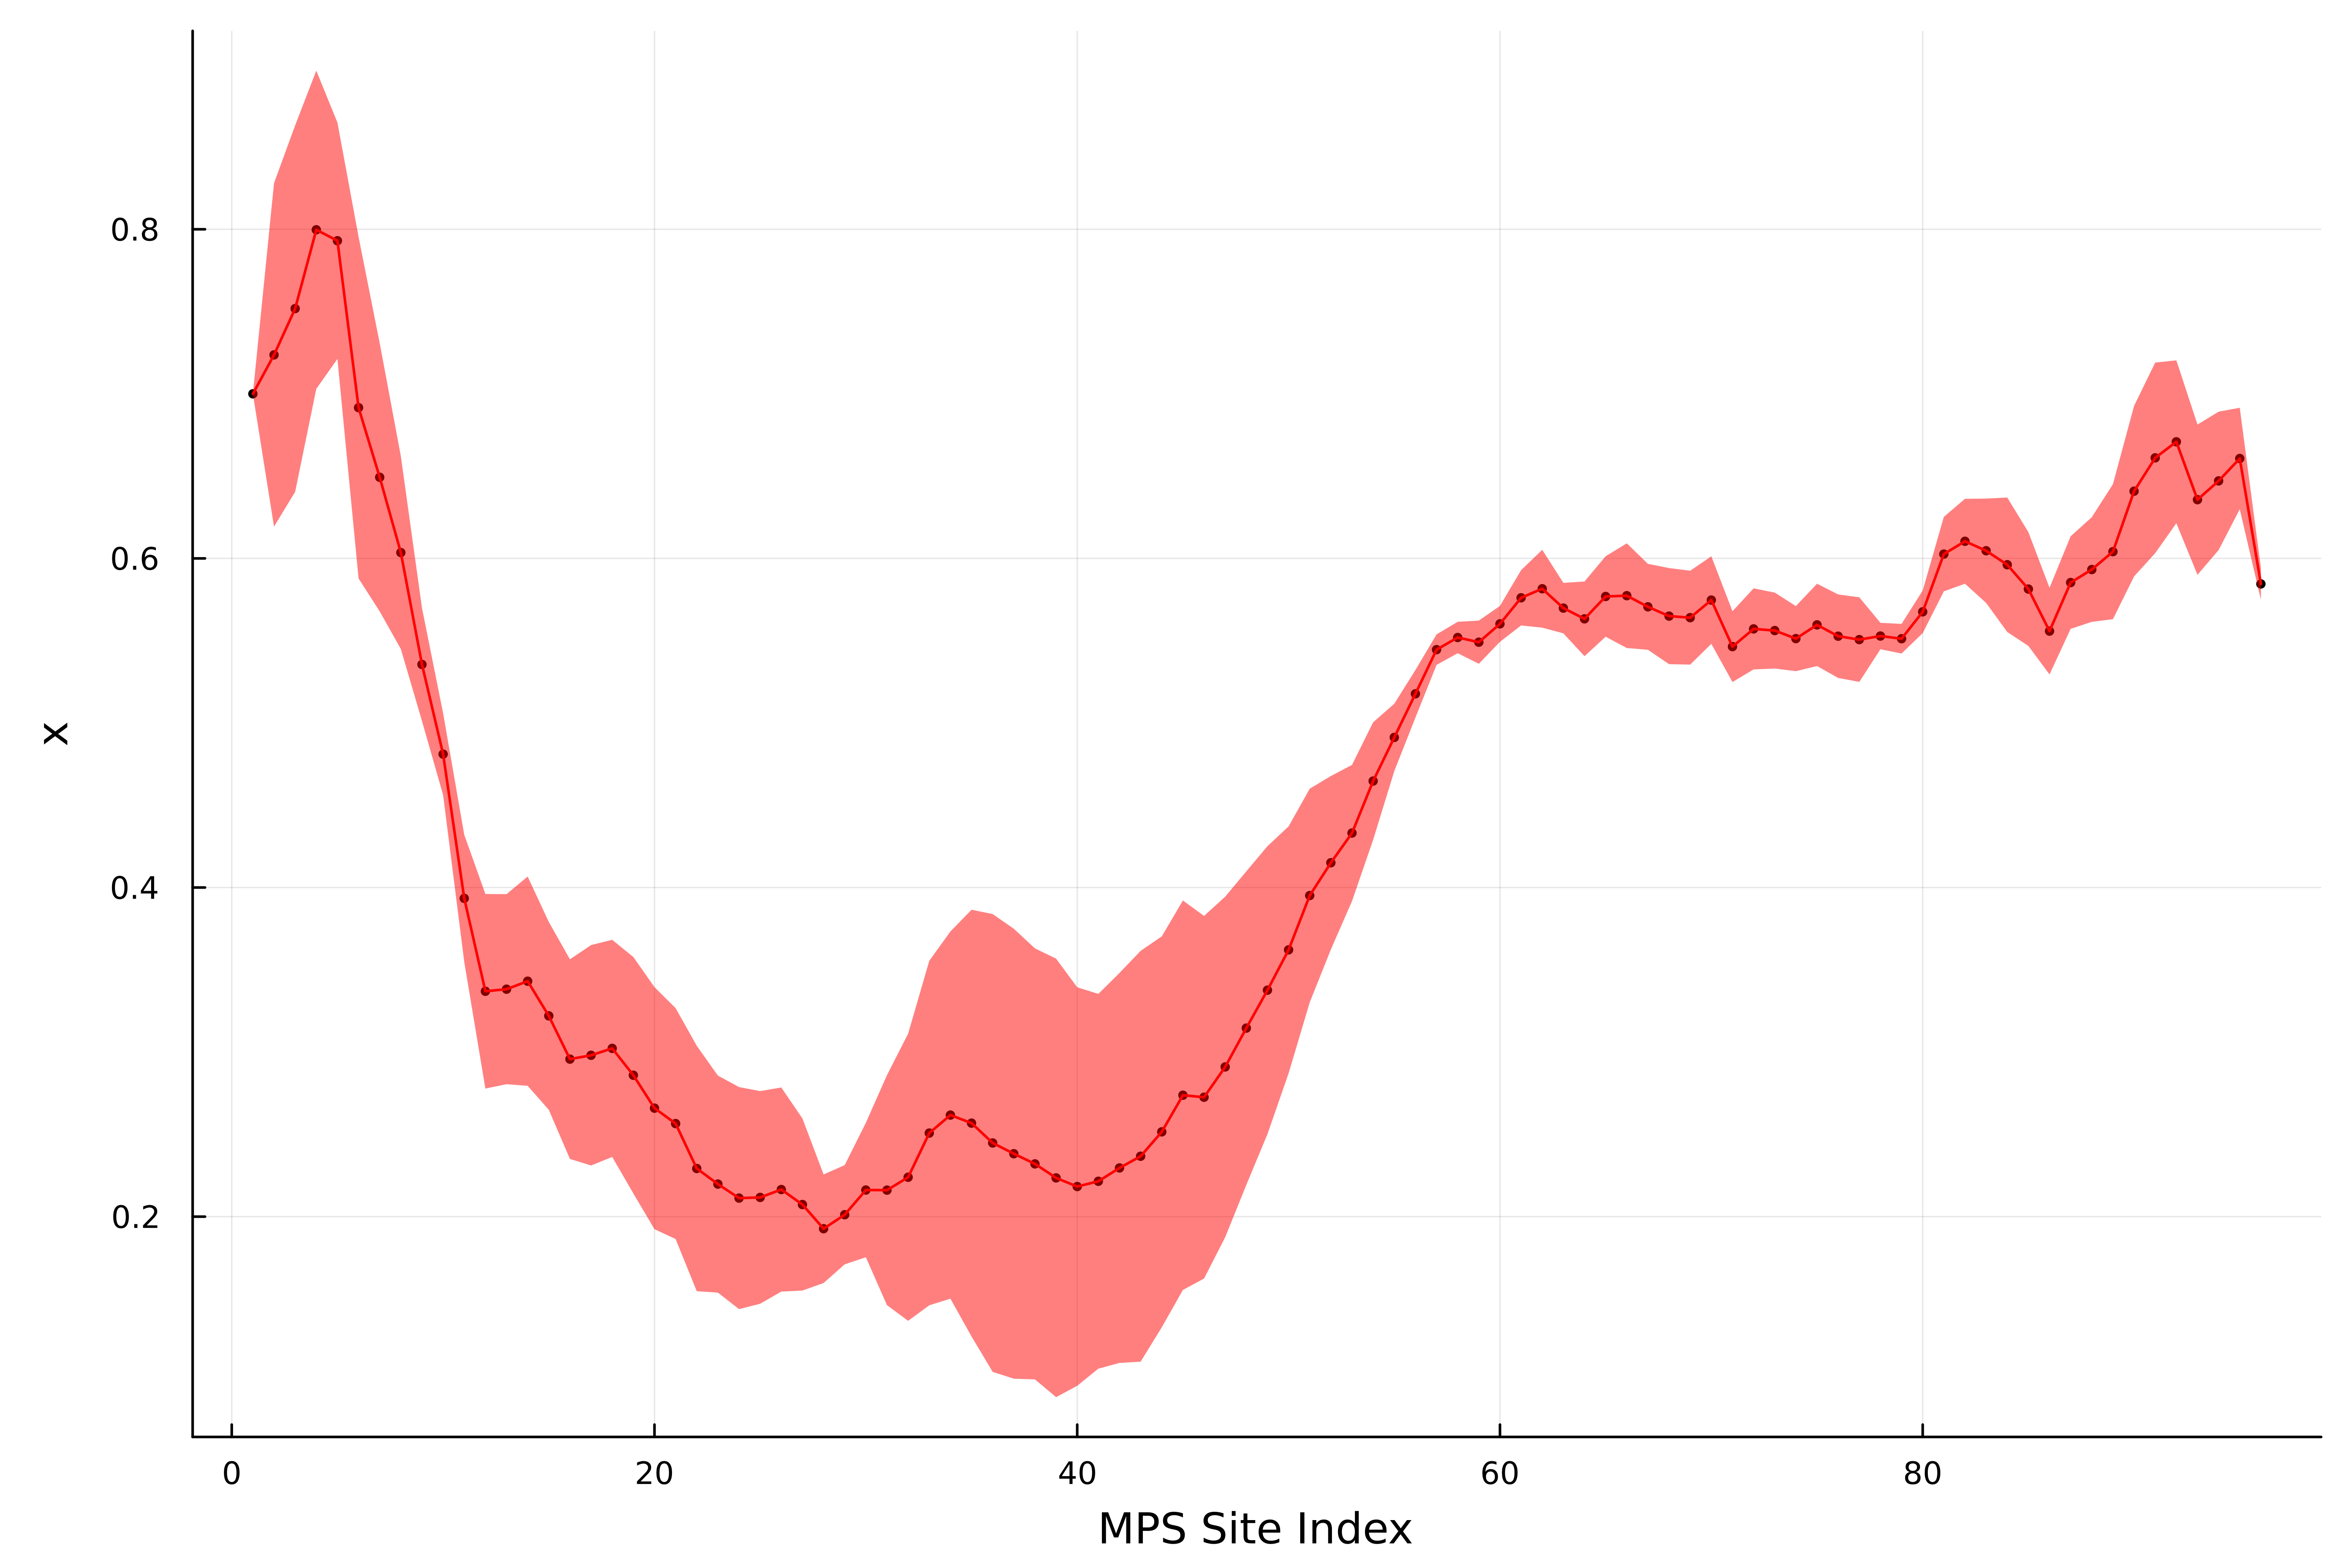

In [339]:
scatter(mean(sims), ms=2, color=:black, label="", size=(900, 600), left_margin=5mm, bottom_margin=2mm, dpi=600)
plot!(mean(sims), color=:red, ribbon=std(sims), label="")
xlabel!("MPS Site Index")
ylabel!("x")
#savefig("MonteCarlo_State1_10000_sims.png")